<a href="https://colab.research.google.com/github/Zohrae/TPDL/blob/main/TP_05_DL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**TD-TP5 : RNN, LSTM et GRU - Airline Passengers**

In [ ]:
# ============================================================================
# ÉTAPE 1 : Installation et Import des bibliothèques
# ============================================================================
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import kagglehub
import os
import warnings
warnings.filterwarnings('ignore')

print("✓ Bibliothèques importées avec succès")

✓ Bibliothèques importées avec succès


In [ ]:
!pip install kagglehub

In [ ]:
print("\n=== Téléchargement du dataset depuis Kaggle ===")
path = kagglehub.dataset_download("erogluegemen/airline-passengers")
print("Path to dataset files:", path)


=== Téléchargement du dataset depuis Kaggle ===


100%|██████████| 807/807 [00:00<00:00, 2.01MB/s]

Extracting files...
Path to dataset files: /root/.cache/kagglehub/datasets/erogluegemen/airline-passengers/versions/1


In [ ]:
# Trouver le fichier CSV dans le dossier téléchargé
csv_files = []
for root, dirs, files in os.walk(path):
    for file in files:
        if file.endswith('.csv'):
            csv_files.append(os.path.join(root, file))

if csv_files:
    csv_path = csv_files[0]
    print(f"✓ Fichier CSV trouvé : {csv_path}")
else:
    raise FileNotFoundError("Aucun fichier CSV trouvé dans le dataset téléchargé")


✓ Fichier CSV trouvé : /root/.cache/kagglehub/datasets/erogluegemen/airline-passengers/versions/1/airline-passengers.csv



=== Aperçu des données ===
     month  total_passengers
0  1949-01               112
1  1949-02               118
2  1949-03               132
3  1949-04               129
4  1949-05               121

Shape du dataset : (144, 2)


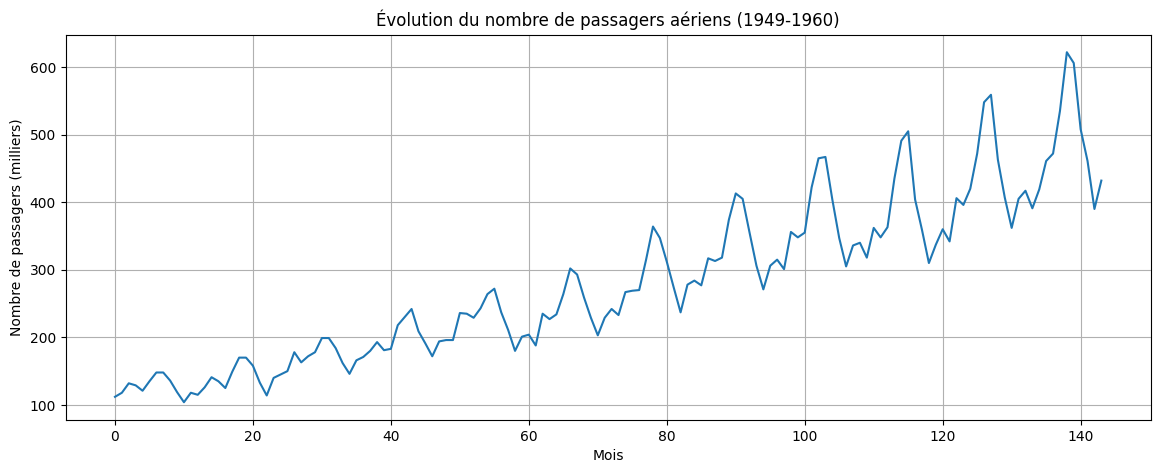

✓ Dataset chargé : 144 observations


In [ ]:
# ============================================================================
# ÉTAPE 4 : Chargement et visualisation des données
# ============================================================================
df = pd.read_csv(csv_path)
print("\n=== Aperçu des données ===")
print(df.head())
print(f"\nShape du dataset : {df.shape}")

# Suppression de la colonne 'Month'
df.drop(['month'], axis=1, inplace=True)

# Conversion en array numpy
dataset = np.array(df)
dataset = dataset.reshape(-1, 1)

# Visualisation
plt.figure(figsize=(14, 5))
plt.plot(dataset)
plt.title('Évolution du nombre de passagers aériens (1949-1960)')
plt.xlabel('Mois')
plt.ylabel('Nombre de passagers (milliers)')
plt.grid(True)
plt.show()

print(f"✓ Dataset chargé : {dataset.shape[0]} observations")


In [ ]:
# ============================================================================
# ÉTAPE 4 : Normalisation des données
# ============================================================================
scaler = MinMaxScaler()
dataset = scaler.fit_transform(dataset)
print("✓ Données normalisées entre 0 et 1")

✓ Données normalisées entre 0 et 1


In [ ]:
# ============================================================================
# ÉTAPE 5 : Division Train/Test (75% / 25%)
# ============================================================================
train_size = int(len(dataset) * 0.75)
test_size = len(dataset) - train_size
train = dataset[:train_size, :]
test = dataset[train_size:, :]

print(f"\n=== Division des données ===")
print(f"Train size : {train_size}")
print(f"Test size : {test_size}")


=== Division des données ===
Train size : 108
Test size : 36


In [ ]:
# ============================================================================
# ÉTAPE 6 : Fonction pour créer les séquences temporelles
# ============================================================================
def getdata(data, lookback):
    """
    Transforme une série temporelle en séquences (X) et valeurs cibles (Y)

    Paramètres:
    - data: série temporelle normalisée
    - lookback: nombre de pas de temps passés à utiliser pour prédire

    Retourne:
    - X: séquences d'entrée (valeurs t-lookback à t-1)
    - Y: valeurs cibles (valeur t)
    """
    X, Y = [], []
    for i in range(len(data) - lookback - 1):
        X.append(data[i:i+lookback, 0])
        Y.append(data[i+lookback, 0])
    return np.array(X), np.array(Y).reshape(-1, 1)

# Lookback = 1 : on utilise uniquement la valeur t-1 pour prédire t
lookback = 1
print(f"\n=== Configuration ===")
print(f"Lookback : {lookback} (on utilise les {lookback} dernière(s) valeur(s) pour prédire)")



=== Configuration ===
Lookback : 1 (on utilise les 1 dernière(s) valeur(s) pour prédire)


In [ ]:
# ============================================================================
# ÉTAPE 7 : Préparation des données d'entraînement et de test
# ============================================================================
X_train, y_train = getdata(train, lookback)
X_test, y_test = getdata(test, lookback)

# Reshape pour Keras : (samples, timesteps, features)
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

print(f"\n=== Forme des données préparées ===")
print(f"X_train shape : {X_train.shape} (samples={X_train.shape[0]}, timesteps={X_train.shape[1]}, features={X_train.shape[2]})")
print(f"y_train shape : {y_train.shape}")
print(f"X_test shape : {X_test.shape}")
print(f"y_test shape : {y_test.shape}")



=== Forme des données préparées ===
X_train shape : (106, 1, 1) (samples=106, timesteps=1, features=1)
y_train shape : (106, 1)
X_test shape : (34, 1, 1)
y_test shape : (34, 1)


In [ ]:
# ============================================================================
# ÉTAPE 8 : Construction du modèle RNN Simple
# ============================================================================
print("\n" + "="*80)
print("MODÈLE 1 : SimpleRNN")
print("="*80)

model_rnn = Sequential()
# Couche SimpleRNN avec 5 neurones récurrents
model_rnn.add(SimpleRNN(5, input_shape=(lookback, 1)))
# Couche Dense pour la prédiction finale
model_rnn.add(Dense(1))
# Compilation : MSE comme fonction de perte, Adam comme optimiseur
model_rnn.compile(loss='mean_squared_error', optimizer='adam')

print("\n--- Architecture du modèle RNN ---")
model_rnn.summary()


MODÈLE 1 : SimpleRNN

--- Architecture du modèle RNN ---


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn (SimpleRNN)          │ (None, 5)              │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 41 (164.00 B)

 Trainable params: 41 (164.00 B)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# ============================================================================
# ÉTAPE 9 : Entraînement du modèle RNN
# ============================================================================
print("\n--- Entraînement en cours (50 epochs) ---")
history_rnn = model_rnn.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0)
print("✓ Entraînement terminé")

# Prédiction sur l'ensemble de test
y_pred_rnn = model_rnn.predict(X_test, verbose=0)

# Dénormalisation des prédictions et des vraies valeurs
y_test_original = scaler.inverse_transform(y_test)
y_pred_rnn_original = scaler.inverse_transform(y_pred_rnn)



--- Entraînement en cours (50 epochs) ---
✓ Entraînement terminé


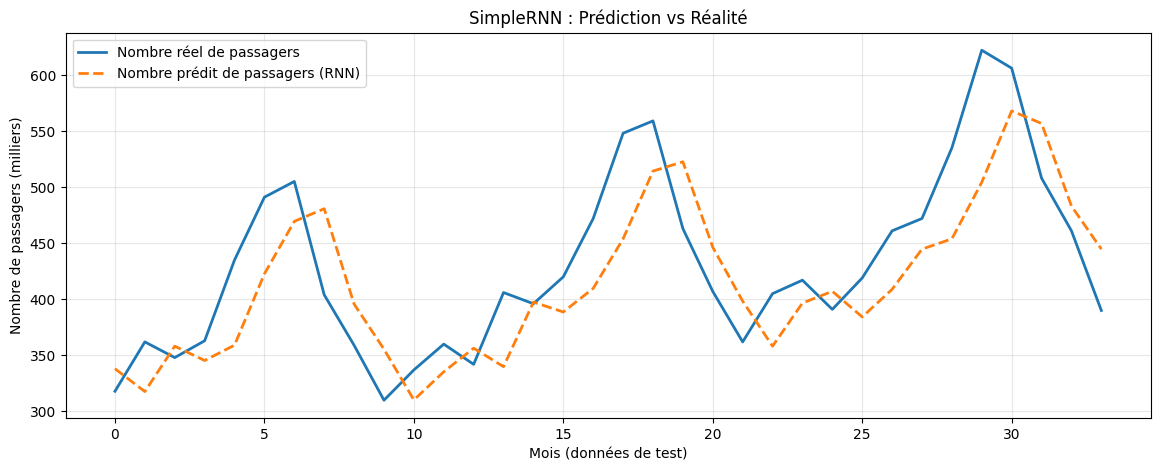

In [ ]:
# ============================================================================
# ÉTAPE 10 : Visualisation des résultats RNN
# ============================================================================
plt.figure(figsize=(14, 5))
plt.plot(y_test_original, label='Nombre réel de passagers', linewidth=2)
plt.plot(y_pred_rnn_original, label='Nombre prédit de passagers (RNN)', linewidth=2, linestyle='--')
plt.title('SimpleRNN : Prédiction vs Réalité')
plt.xlabel('Mois (données de test)')
plt.ylabel('Nombre de passagers (milliers)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [ ]:
# ============================================================================
# ÉTAPE 11 : Calcul de l'erreur MSE
# ============================================================================
mse_rnn = mean_squared_error(y_test_original, y_pred_rnn_original)
print(f"\n--- Erreur Quadratique Moyenne (MSE) RNN : {mse_rnn:.2f} ---")



--- Erreur Quadratique Moyenne (MSE) RNN : 2562.08 ---


In [ ]:
# ============================================================================
# ÉTAPE 11 : Calcul de l'erreur MSE
# ============================================================================
mse_rnn = mean_squared_error(y_test_original, y_pred_rnn_original)
print(f"\n--- Erreur Quadratique Moyenne (MSE) RNN : {mse_rnn:.2f} ---")



--- Erreur Quadratique Moyenne (MSE) RNN : 2562.08 ---



MODÈLE 2 : LSTM

--- Architecture du modèle LSTM ---


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 5)              │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 146 (584.00 B)

 Trainable params: 146 (584.00 B)

 Non-trainable params: 0 (0.00 B)


--- Entraînement en cours (50 epochs) ---
✓ Entraînement terminé


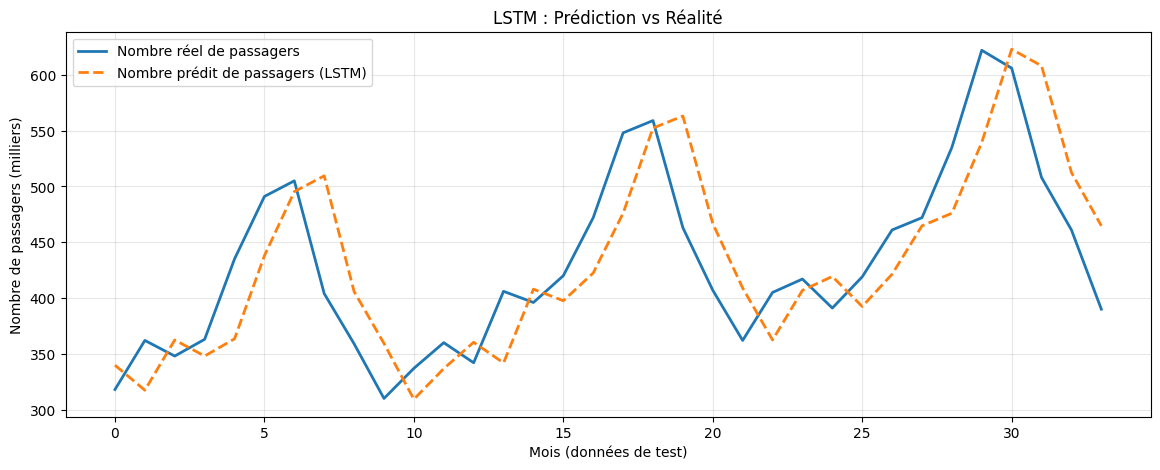


--- Erreur Quadratique Moyenne (MSE) LSTM : 2659.92 ---


In [ ]:
# ============================================================================
# MODÈLE 2 : LSTM
# ============================================================================
print("\n" + "="*80)
print("MODÈLE 2 : LSTM")
print("="*80)

model_lstm = Sequential()
# Couche LSTM avec 5 neurones (LSTM = meilleure mémoire long terme que RNN)
model_lstm.add(LSTM(5, input_shape=(lookback, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(loss='mean_squared_error', optimizer='adam')

print("\n--- Architecture du modèle LSTM ---")
model_lstm.summary()

print("\n--- Entraînement en cours (50 epochs) ---")
history_lstm = model_lstm.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0)
print("✓ Entraînement terminé")

# Prédiction
y_pred_lstm = model_lstm.predict(X_test, verbose=0)
y_pred_lstm_original = scaler.inverse_transform(y_pred_lstm)

# Visualisation
plt.figure(figsize=(14, 5))
plt.plot(y_test_original, label='Nombre réel de passagers', linewidth=2)
plt.plot(y_pred_lstm_original, label='Nombre prédit de passagers (LSTM)', linewidth=2, linestyle='--')
plt.title('LSTM : Prédiction vs Réalité')
plt.xlabel('Mois (données de test)')
plt.ylabel('Nombre de passagers (milliers)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calcul MSE
mse_lstm = mean_squared_error(y_test_original, y_pred_lstm_original)
print(f"\n--- Erreur Quadratique Moyenne (MSE) LSTM : {mse_lstm:.2f} ---")



MODÈLE 3 : GRU

--- Architecture du modèle GRU ---


Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru (GRU)                       │ (None, 5)              │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 126 (504.00 B)

 Trainable params: 126 (504.00 B)

 Non-trainable params: 0 (0.00 B)


--- Entraînement en cours (50 epochs) ---


✓ Entraînement terminé


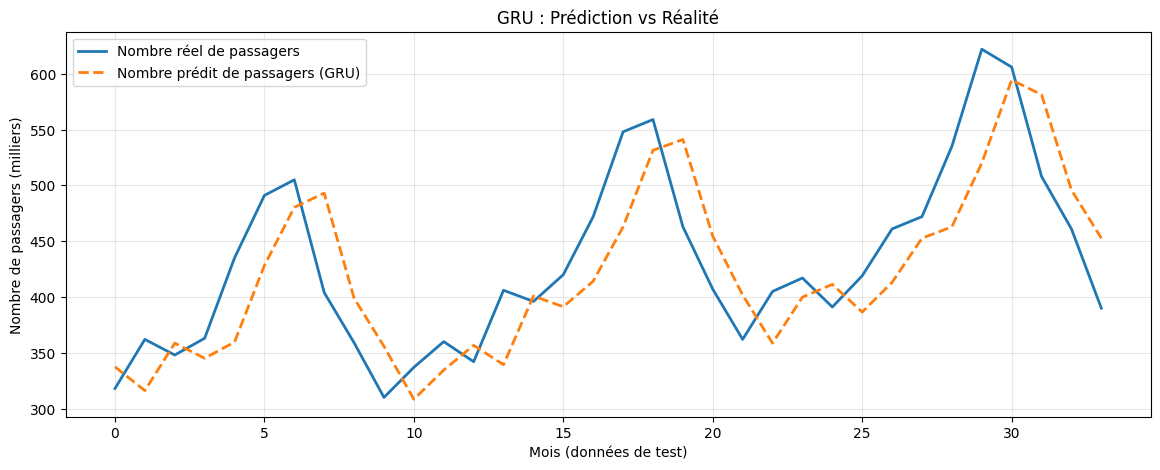


--- Erreur Quadratique Moyenne (MSE) GRU : 2524.93 ---


In [ ]:
# ============================================================================
# MODÈLE 3 : GRU
# ============================================================================
print("\n" + "="*80)
print("MODÈLE 3 : GRU")
print("="*80)

model_gru = Sequential()
# Couche GRU avec 5 neurones (GRU = version simplifiée du LSTM, plus rapide)
model_gru.add(GRU(5, input_shape=(lookback, 1)))
model_gru.add(Dense(1))
model_gru.compile(loss='mean_squared_error', optimizer='adam')

print("\n--- Architecture du modèle GRU ---")
model_gru.summary()

print("\n--- Entraînement en cours (50 epochs) ---")
history_gru = model_gru.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0)
print("✓ Entraînement terminé")

# Prédiction
y_pred_gru = model_gru.predict(X_test, verbose=0)
y_pred_gru_original = scaler.inverse_transform(y_pred_gru)

# Visualisation
plt.figure(figsize=(14, 5))
plt.plot(y_test_original, label='Nombre réel de passagers', linewidth=2)
plt.plot(y_pred_gru_original, label='Nombre prédit de passagers (GRU)', linewidth=2, linestyle='--')
plt.title('GRU : Prédiction vs Réalité')
plt.xlabel('Mois (données de test)')
plt.ylabel('Nombre de passagers (milliers)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# Calcul MSE
mse_gru = mean_squared_error(y_test_original, y_pred_gru_original)
print(f"\n--- Erreur Quadratique Moyenne (MSE) GRU : {mse_gru:.2f} ---")


In [ ]:
# ============================================================================
# COMPARAISON DES 3 MODÈLES (Lookback = 1)
# ============================================================================
print("\n" + "="*80)
print("COMPARAISON DES 3 MODÈLES (Lookback = 1)")
print("="*80)
print(f"MSE SimpleRNN : {mse_rnn:.2f}")
print(f"MSE LSTM      : {mse_lstm:.2f}")
print(f"MSE GRU       : {mse_gru:.2f}")



COMPARAISON DES 3 MODÈLES (Lookback = 1)
MSE SimpleRNN : 2562.08
MSE LSTM      : 2659.92
MSE GRU       : 2524.93


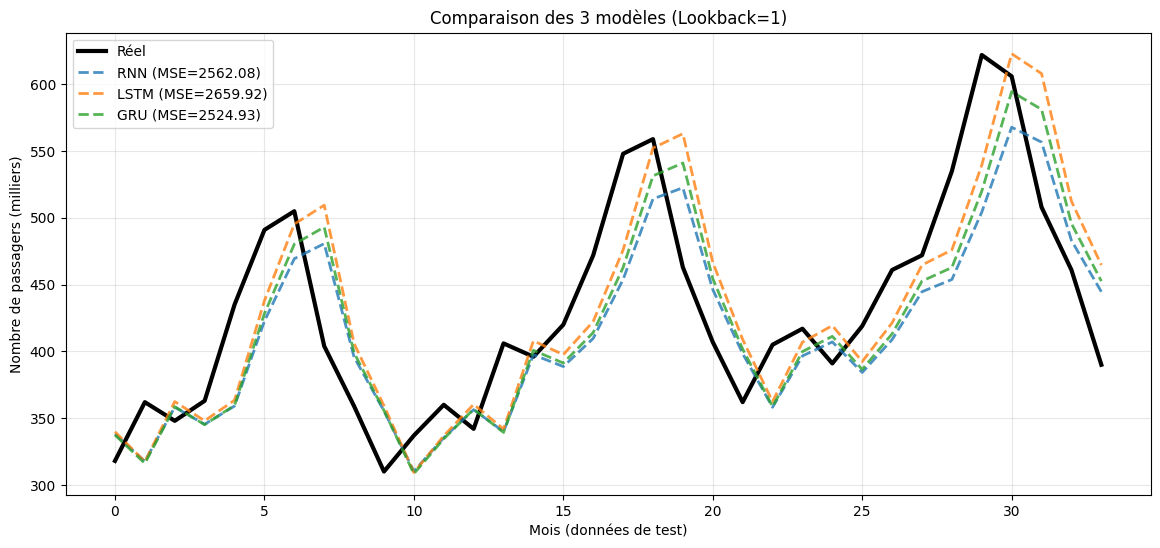

In [ ]:
# Visualisation comparative
plt.figure(figsize=(14, 6))
plt.plot(y_test_original, label='Réel', linewidth=3, color='black')
plt.plot(y_pred_rnn_original, label=f'RNN (MSE={mse_rnn:.2f})', linewidth=2, linestyle='--', alpha=0.8)
plt.plot(y_pred_lstm_original, label=f'LSTM (MSE={mse_lstm:.2f})', linewidth=2, linestyle='--', alpha=0.8)
plt.plot(y_pred_gru_original, label=f'GRU (MSE={mse_gru:.2f})', linewidth=2, linestyle='--', alpha=0.8)
plt.title('Comparaison des 3 modèles (Lookback=1)')
plt.xlabel('Mois (données de test)')
plt.ylabel('Nombre de passagers (milliers)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


QUESTION 3 : LOOKBACK = 2 (utiliser les 2 dernières valeurs)

X_train_2 shape : (105, 2, 1)
X_test_2 shape : (33, 2, 1)

--- SimpleRNN (Lookback=2) ---
MSE RNN (Lookback=2) : 2463.49

--- LSTM (Lookback=2) ---
MSE LSTM (Lookback=2) : 4208.50

--- GRU (Lookback=2) ---
MSE GRU (Lookback=2) : 2802.42


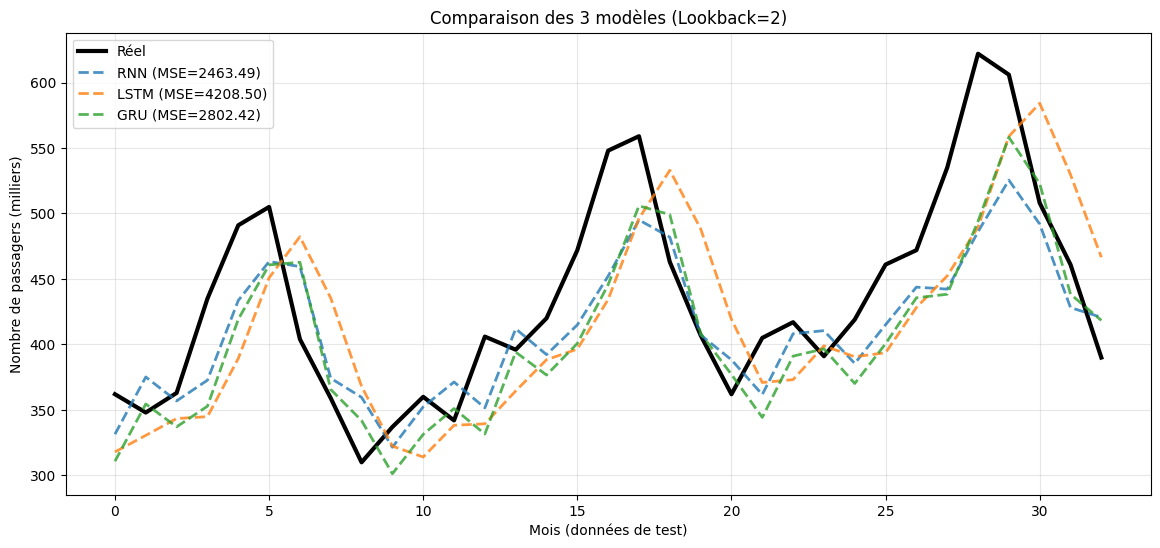

In [ ]:
# ============================================================================
# QUESTION 3 : Test avec Lookback = 2
# ============================================================================
print("\n" + "="*80)
print("QUESTION 3 : LOOKBACK = 2 (utiliser les 2 dernières valeurs)")
print("="*80)

lookback = 2

# Préparation des données avec lookback=2
X_train_2, y_train_2 = getdata(train, lookback)
X_test_2, y_test_2 = getdata(test, lookback)

X_train_2 = X_train_2.reshape(X_train_2.shape[0], X_train_2.shape[1], 1)
X_test_2 = X_test_2.reshape(X_test_2.shape[0], X_test_2.shape[1], 1)

print(f"\nX_train_2 shape : {X_train_2.shape}")
print(f"X_test_2 shape : {X_test_2.shape}")

# --- RNN avec lookback=2 ---
print("\n--- SimpleRNN (Lookback=2) ---")
model_rnn_2 = Sequential()
model_rnn_2.add(SimpleRNN(5, input_shape=(lookback, 1)))
model_rnn_2.add(Dense(1))
model_rnn_2.compile(loss='mean_squared_error', optimizer='adam')
model_rnn_2.fit(X_train_2, y_train_2, epochs=50, batch_size=1, verbose=0)

y_pred_rnn_2 = model_rnn_2.predict(X_test_2, verbose=0)
y_test_2_original = scaler.inverse_transform(y_test_2)
y_pred_rnn_2_original = scaler.inverse_transform(y_pred_rnn_2)
mse_rnn_2 = mean_squared_error(y_test_2_original, y_pred_rnn_2_original)
print(f"MSE RNN (Lookback=2) : {mse_rnn_2:.2f}")

# --- LSTM avec lookback=2 ---
print("\n--- LSTM (Lookback=2) ---")
model_lstm_2 = Sequential()
model_lstm_2.add(LSTM(5, input_shape=(lookback, 1)))
model_lstm_2.add(Dense(1))
model_lstm_2.compile(loss='mean_squared_error', optimizer='adam')
model_lstm_2.fit(X_train_2, y_train_2, epochs=50, batch_size=1, verbose=0)

y_pred_lstm_2 = model_lstm_2.predict(X_test_2, verbose=0)
y_pred_lstm_2_original = scaler.inverse_transform(y_pred_lstm_2)
mse_lstm_2 = mean_squared_error(y_test_2_original, y_pred_lstm_2_original)
print(f"MSE LSTM (Lookback=2) : {mse_lstm_2:.2f}")

# --- GRU avec lookback=2 ---
print("\n--- GRU (Lookback=2) ---")
model_gru_2 = Sequential()
model_gru_2.add(GRU(5, input_shape=(lookback, 1)))
model_gru_2.add(Dense(1))
model_gru_2.compile(loss='mean_squared_error', optimizer='adam')
model_gru_2.fit(X_train_2, y_train_2, epochs=50, batch_size=1, verbose=0)

y_pred_gru_2 = model_gru_2.predict(X_test_2, verbose=0)
y_pred_gru_2_original = scaler.inverse_transform(y_pred_gru_2)
mse_gru_2 = mean_squared_error(y_test_2_original, y_pred_gru_2_original)
print(f"MSE GRU (Lookback=2) : {mse_gru_2:.2f}")

# Visualisation comparative lookback=2
plt.figure(figsize=(14, 6))
plt.plot(y_test_2_original, label='Réel', linewidth=3, color='black')
plt.plot(y_pred_rnn_2_original, label=f'RNN (MSE={mse_rnn_2:.2f})', linewidth=2, linestyle='--', alpha=0.8)
plt.plot(y_pred_lstm_2_original, label=f'LSTM (MSE={mse_lstm_2:.2f})', linewidth=2, linestyle='--', alpha=0.8)
plt.plot(y_pred_gru_2_original, label=f'GRU (MSE={mse_gru_2:.2f})', linewidth=2, linestyle='--', alpha=0.8)
plt.title('Comparaison des 3 modèles (Lookback=2)')
plt.xlabel('Mois (données de test)')
plt.ylabel('Nombre de passagers (milliers)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



QUESTION 4 : MODÈLES AVEC 2 COUCHES DE NEURONES RÉCURRENTS

--- SimpleRNN (2 couches) ---


Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ simple_rnn_2 (SimpleRNN)        │ (None, 1, 5)           │            35 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_3 (SimpleRNN)        │ (None, 5)              │            55 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 96 (384.00 B)

 Trainable params: 96 (384.00 B)

 Non-trainable params: 0 (0.00 B)

MSE RNN (2 couches) : 2762.36

--- LSTM (2 couches) ---


Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                   │ (None, 1, 5)           │           140 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_3 (LSTM)                   │ (None, 5)              │           220 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 366 (1.43 KB)

 Trainable params: 366 (1.43 KB)

 Non-trainable params: 0 (0.00 B)

MSE LSTM (2 couches) : 2364.73

--- GRU (2 couches) ---


Model: "sequential_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_2 (GRU)                     │ (None, 1, 5)           │           120 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 5)              │           180 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 1)              │             6 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 306 (1.20 KB)

 Trainable params: 306 (1.20 KB)

 Non-trainable params: 0 (0.00 B)

MSE GRU (2 couches) : 2369.62


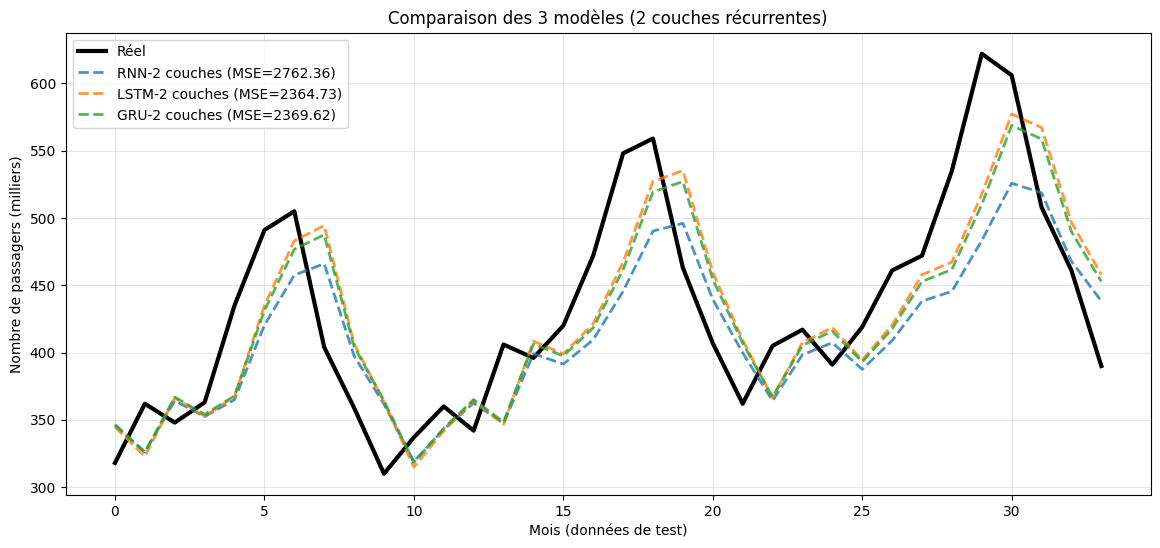

In [ ]:
# ============================================================================
# QUESTION 4 : Modèles avec 2 couches de neurones récurrents
# ============================================================================
print("\n" + "="*80)
print("QUESTION 4 : MODÈLES AVEC 2 COUCHES DE NEURONES RÉCURRENTS")
print("="*80)

lookback = 1  # Retour à lookback=1

# --- RNN à 2 couches ---
print("\n--- SimpleRNN (2 couches) ---")
model_rnn_deep = Sequential()
# 1ère couche : return_sequences=True pour transmettre la séquence à la 2ème couche
model_rnn_deep.add(SimpleRNN(5, input_shape=(lookback, 1), return_sequences=True))
# 2ème couche RNN
model_rnn_deep.add(SimpleRNN(5))
model_rnn_deep.add(Dense(1))
model_rnn_deep.compile(loss='mean_squared_error', optimizer='adam')
model_rnn_deep.summary()

model_rnn_deep.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0)
y_pred_rnn_deep = model_rnn_deep.predict(X_test, verbose=0)
y_pred_rnn_deep_original = scaler.inverse_transform(y_pred_rnn_deep)
mse_rnn_deep = mean_squared_error(y_test_original, y_pred_rnn_deep_original)
print(f"MSE RNN (2 couches) : {mse_rnn_deep:.2f}")

# --- LSTM à 2 couches ---
print("\n--- LSTM (2 couches) ---")
model_lstm_deep = Sequential()
model_lstm_deep.add(LSTM(5, input_shape=(lookback, 1), return_sequences=True))
model_lstm_deep.add(LSTM(5))
model_lstm_deep.add(Dense(1))
model_lstm_deep.compile(loss='mean_squared_error', optimizer='adam')
model_lstm_deep.summary()

model_lstm_deep.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0)
y_pred_lstm_deep = model_lstm_deep.predict(X_test, verbose=0)
y_pred_lstm_deep_original = scaler.inverse_transform(y_pred_lstm_deep)
mse_lstm_deep = mean_squared_error(y_test_original, y_pred_lstm_deep_original)
print(f"MSE LSTM (2 couches) : {mse_lstm_deep:.2f}")

# --- GRU à 2 couches ---
print("\n--- GRU (2 couches) ---")
model_gru_deep = Sequential()
model_gru_deep.add(GRU(5, input_shape=(lookback, 1), return_sequences=True))
model_gru_deep.add(GRU(5))
model_gru_deep.add(Dense(1))
model_gru_deep.compile(loss='mean_squared_error', optimizer='adam')
model_gru_deep.summary()

model_gru_deep.fit(X_train, y_train, epochs=50, batch_size=1, verbose=0)
y_pred_gru_deep = model_gru_deep.predict(X_test, verbose=0)
y_pred_gru_deep_original = scaler.inverse_transform(y_pred_gru_deep)
mse_gru_deep = mean_squared_error(y_test_original, y_pred_gru_deep_original)
print(f"MSE GRU (2 couches) : {mse_gru_deep:.2f}")

# Visualisation comparative 2 couches
plt.figure(figsize=(14, 6))
plt.plot(y_test_original, label='Réel', linewidth=3, color='black')
plt.plot(y_pred_rnn_deep_original, label=f'RNN-2 couches (MSE={mse_rnn_deep:.2f})', linewidth=2, linestyle='--', alpha=0.8)
plt.plot(y_pred_lstm_deep_original, label=f'LSTM-2 couches (MSE={mse_lstm_deep:.2f})', linewidth=2, linestyle='--', alpha=0.8)
plt.plot(y_pred_gru_deep_original, label=f'GRU-2 couches (MSE={mse_gru_deep:.2f})', linewidth=2, linestyle='--', alpha=0.8)
plt.title('Comparaison des 3 modèles (2 couches récurrentes)')
plt.xlabel('Mois (données de test)')
plt.ylabel('Nombre de passagers (milliers)')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()



TABLEAU RÉCAPITULATIF FINAL DE TOUS LES MODÈLES

Modèle                         MSE            
--------------------------------------------------
RNN (1 couche, lookback=1)     2562.08        
LSTM (1 couche, lookback=1)    2659.92        
GRU (1 couche, lookback=1)     2524.93        
--------------------------------------------------
RNN (1 couche, lookback=2)     2463.49        
LSTM (1 couche, lookback=2)    4208.50        
GRU (1 couche, lookback=2)     2802.42        
--------------------------------------------------
RNN (2 couches, lookback=1)    2762.36        
LSTM (2 couches, lookback=1)   2364.73        
GRU (2 couches, lookback=1)    2369.62        


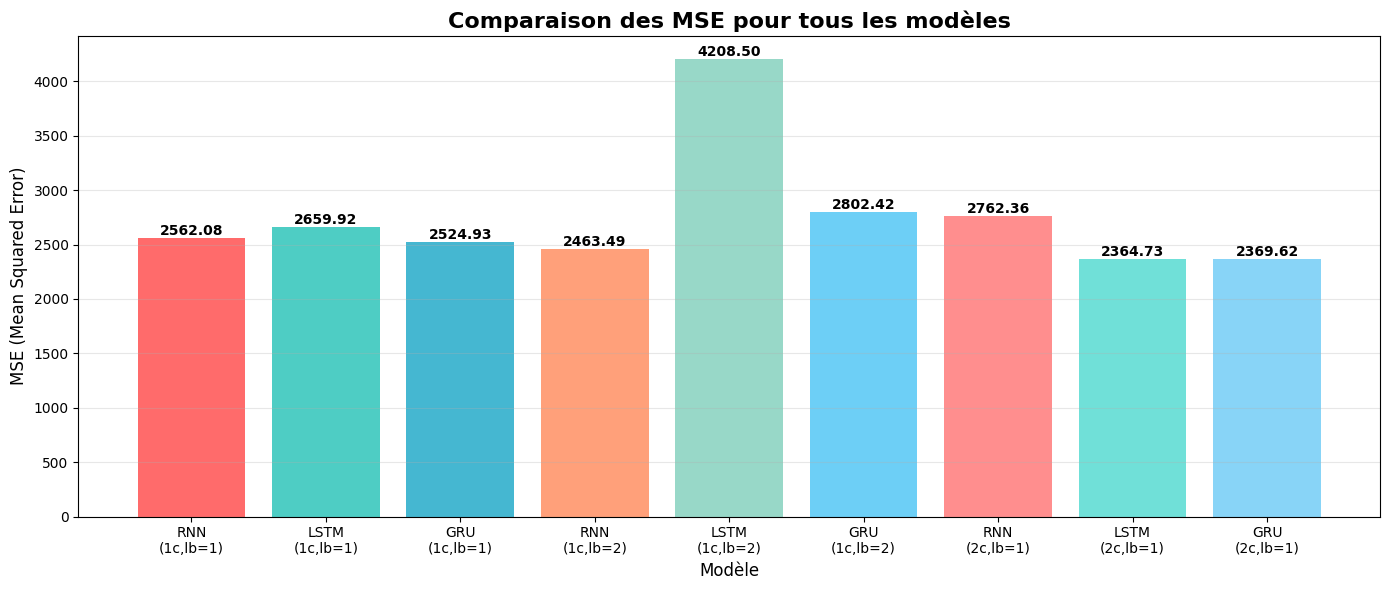


Conclusions :
- LSTM et GRU performent généralement mieux que SimpleRNN
- L'augmentation du lookback peut améliorer ou détériorer les performances
- L'ajout d'une 2ème couche récurrente peut capturer des patterns plus complexes
- Le meilleur modèle dépend de la configuration spécifique (architecture + hyperparamètres)


In [ ]:
# ============================================================================
# TABLEAU RÉCAPITULATIF FINAL
# ============================================================================
print("\n" + "="*80)
print("TABLEAU RÉCAPITULATIF FINAL DE TOUS LES MODÈLES")
print("="*80)
print("\n{:<30} {:<15}".format("Modèle", "MSE"))
print("-" * 50)
print("{:<30} {:<15.2f}".format("RNN (1 couche, lookback=1)", mse_rnn))
print("{:<30} {:<15.2f}".format("LSTM (1 couche, lookback=1)", mse_lstm))
print("{:<30} {:<15.2f}".format("GRU (1 couche, lookback=1)", mse_gru))
print("-" * 50)
print("{:<30} {:<15.2f}".format("RNN (1 couche, lookback=2)", mse_rnn_2))
print("{:<30} {:<15.2f}".format("LSTM (1 couche, lookback=2)", mse_lstm_2))
print("{:<30} {:<15.2f}".format("GRU (1 couche, lookback=2)", mse_gru_2))
print("-" * 50)
print("{:<30} {:<15.2f}".format("RNN (2 couches, lookback=1)", mse_rnn_deep))
print("{:<30} {:<15.2f}".format("LSTM (2 couches, lookback=1)", mse_lstm_deep))
print("{:<30} {:<15.2f}".format("GRU (2 couches, lookback=1)", mse_gru_deep))
print("="*80)

# Graphique comparatif des MSE
models = ['RNN\n(1c,lb=1)', 'LSTM\n(1c,lb=1)', 'GRU\n(1c,lb=1)',
          'RNN\n(1c,lb=2)', 'LSTM\n(1c,lb=2)', 'GRU\n(1c,lb=2)',
          'RNN\n(2c,lb=1)', 'LSTM\n(2c,lb=1)', 'GRU\n(2c,lb=1)']
mses = [mse_rnn, mse_lstm, mse_gru,
        mse_rnn_2, mse_lstm_2, mse_gru_2,
        mse_rnn_deep, mse_lstm_deep, mse_gru_deep]

plt.figure(figsize=(14, 6))
bars = plt.bar(models, mses, color=['#FF6B6B', '#4ECDC4', '#45B7D1',
                                      '#FFA07A', '#98D8C8', '#6DCFF6',
                                      '#FF8E8E', '#70E0D8', '#88D4F7'])
plt.title('Comparaison des MSE pour tous les modèles', fontsize=16, fontweight='bold')
plt.xlabel('Modèle', fontsize=12)
plt.ylabel('MSE (Mean Squared Error)', fontsize=12)
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)

# Ajouter les valeurs sur les barres
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height,
             f'{height:.2f}',
             ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()

print("\nConclusions :")
print("- LSTM et GRU performent généralement mieux que SimpleRNN")
print("- L'augmentation du lookback peut améliorer ou détériorer les performances")
print("- L'ajout d'une 2ème couche récurrente peut capturer des patterns plus complexes")
print("- Le meilleur modèle dépend de la configuration spécifique (architecture + hyperparamètres)")